In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from environment.pyGameWorld import loadFromDict
from sklearn.mixture import GaussianMixture
from scipy import spatial
import warnings
warnings.filterwarnings("ignore")

/Users/solimlegris/opt/anaconda3/envs/tool-game/lib/python3.9/site-packages/cffi/cparser.py:163: UserWarning: Global variable '_cpBBNewForExtents' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  warnings.warn("Global variable '%s' in cdef(): for consistency "
/Users/solimlegris/opt/anaconda3/envs/tool-game/lib/python3.9/site-packages/cffi/cparser.py:163: UserWarning: Global variable '_cpBBNewForCircle' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  warnings.warn("Global variable '%s' in cdef(): for consistency "
/Users/solimlegris/opt/anaconda3/envs/tool-game/lib/python3.9/site-packages/cffi/cparser.py:163: UserWarning: Global variable '_cpBBIntersects' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  warnings.warn("Global variable '%s' in cdef(): for consistency "
/Users/solimlegris/opt/anaconda3/envs/tool-game/lib/python3.9/site-packages/cffi

Loading chipmunk for Darwin (64bit) [/Users/solimlegris/opt/anaconda3/envs/tool-game/lib/python3.9/site-packages/pymunk/libchipmunk.dylib]
pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Initial data exploration

In [4]:
# load data from csv
data = pd.read_csv(os.path.join('data', 'original_levels', 'humans', 'FullGameSuccessData.csv'))
data = data[data['SuccessTrial'] == True]
data

,ID,Trial,AttemptNum,Tool,PosX,PosY,Time,SuccessTrial,TrialOrder,SuccessPlace
0,Subj_1,Shafts_B,0,obj1,94.0,558.0,16669,True,10,False
7,Subj_1,Shafts_B,1,obj2,90.0,572.0,20721,True,10,False
8,Subj_1,Shafts_B,2,obj3,84.0,567.0,27481,True,10,False
9,Subj_1,Shafts_B,3,obj3,66.0,574.0,33718,True,10,False
10,Subj_1,Towers_B,0,obj1,303.0,548.0,3739,True,16,False
...,...,...,...,...,...,...,...,...,...,...
6542,Subj_94,Unbox,2,obj2,523.0,232.0,20423,True,10,False
6543,Subj_94,Unbox,3,obj1,515.0,513.0,27437,True,10,True
6544,Subj_94,Unbox,4,obj1,521.0,503.0,34203,True,10,True
6545,Subj_94,Unsupport,0,obj3,37.0,564.0,9684,True,12,False


In [5]:
# sort by ID, Trial, AttemptNum
data.sort_values(by=['ID', 'Trial', 'AttemptNum'], inplace=True)
# compute inter trial time
data['Time'] = data.groupby(['ID', 'Trial'])['Time'].transform(lambda x: x.diff() if len(x) > 1 else x).fillna(data['Time'])
data

,ID,Trial,AttemptNum,Tool,PosX,PosY,Time,SuccessTrial,TrialOrder,SuccessPlace
102,Subj_1,Basic,0,obj2,82.0,416.0,3228.0,True,12,True
85,Subj_1,Catapult,0,obj2,457.0,147.0,2985.0,True,7,False
86,Subj_1,Catapult,1,obj1,428.0,127.0,6505.0,True,7,False
87,Subj_1,Catapult,2,obj3,457.0,150.0,3639.0,True,7,False
88,Subj_1,Catapult,3,obj3,399.0,230.0,2953.0,True,7,False
...,...,...,...,...,...,...,...,...,...,...
6542,Subj_94,Unbox,2,obj2,523.0,232.0,7978.0,True,10,False
6543,Subj_94,Unbox,3,obj1,515.0,513.0,7014.0,True,10,True
6544,Subj_94,Unbox,4,obj1,521.0,503.0,6766.0,True,10,True
6545,Subj_94,Unsupport,0,obj3,37.0,564.0,9684.0,True,12,False


## Finding insight moments
The idea here is to find a threshold of change in distance that indicates a change in strategy. One idea I have to accomplish this is to find "cluster jumps". Presumably, people tend to try actions in clustered regions of space (if the object oriented-prior is cognitively plausible) for a given task and switch clusters (or tools) when they realize that the strategy is unsuccessful. If we can find these clusters for each task, then we can compute the last time there was a "cluster jump" indicating a change in strategy. For those with no cluster jump, presumably there may have been a tool change which led to insight. Lastly, there may not have been either of these events, indicating no change in strategy. 

### How to do this?
1. For each task, identify the number of clusters using number of objects that can be acted upon.
2. For each task, find clusters using k-means/Gaussian mixture model algorithm.
3. Find mean number of cluster switches for each problem and look if that aligns well with mean change in distance (proportion of cluster switch and proportion of tool switch).
4. For each participant, grouped by number of attempts (first, then maybe aggregate)
    - find last cluster switch (keep track of how many participants have this for this task)
    - if none, find last object switch (keep track)
    - if none, then aggregate with no strategy switch
5. Plot for each category and task, grouped by number of attempts, the trajectory of changes in distance 

Issues:
- How do I determine the number of clusters for each task? Could do it manually or use a clustering algorithm that can find optimal number of clusters?

### Other ideas

- Look at distribution of z-scored times at insight moment and compare with distribution of times before (n-2) and after 

In [6]:
def getNumDynamicObjects(tnm):
    """
    Function that returns the number of dynamic objects in a trial
    """
    json_dir = "environment/Trials/Original/"
    with open(json_dir + tnm + ".json", 'r') as jfl:
        trial = json.load(jfl)
    # make world
    pgw = loadFromDict(trial['world'])
    # get dynamic objects
    objects = pgw.getDynamicObjects()
    for object in objects:
        print(object.name)
    # check for blockers
    if 'Blocker' in trial['world']['blocks']:
        n_obj = 0
        verts = trial['world']['blocks']['Blocker']['vertices']
        for object in objects:
            pos = object.getPos()
            # verify that object is not in the blocker
            if not (verts[0][0] < pos[0] < verts[2][0] and verts[0][1] < pos[1] < verts[2][1]):
                n_obj += 1
                #print(object.name)
        return n_obj
    else:
        return len(objects)

def getClusteringModel(X, n_components):
    """
    Function that returns a clustering model for the data
    """
    # fit model
    gmm = GaussianMixture(n_components=n_components, random_state=0).fit(X)

    return gmm

def getStatsClusterSwitches(X):
    """
    Function that returns the mean number of cluster switches for a given clustering model on a task
    """
    # get mean number of switches and standard deviation for each ID
    switch_counts = X.groupby(['ID'])['ClusterSwitch'].agg(lambda x: x.eq(1).sum())

    return switch_counts.mean(), switch_counts.std()


def getClustersSwitches(gmm, X):
    """
    Function that returns the list of cluster switches for a given clustering model on a task
    """
    # get cluster assignments
    cluster_assignments = gmm.predict(X[['PosX', 'PosY']])
    # get number of switches
    X['Cluster'] = cluster_assignments
    X = X.sort_values(by=['ID', 'AttemptNum'])
    X['ClusterSwitch'] = X.groupby(['ID'])['Cluster'].diff().fillna(0).astype(int)
    X['ClusterSwitch'].where(X['ClusterSwitch'] == 0, 1, inplace=True)
    return X

def getToolSwitches(X):
    """
    Function that returns the list of tool switches for a given clustering model on a task
    """
    # get number of switches
    X = X.sort_values(by=['ID', 'AttemptNum'])
    X['Tool'] = X['Tool'].map({'obj1': 1, 'obj2': 2, 'obj3': 3})
    X['ToolSwitch'] = X.groupby(['ID'])['Tool'].diff().fillna(0).astype(int)
    X['ToolSwitch'].where(X['ToolSwitch'] == 0, 1, inplace=True)
    return X

def getTimeDist(X):
    """
    Function that returns the z-scored Time and Change in Distance between actions for each participant
    """
    X = X.sort_values(by=['ID', 'AttemptNum'])
    # get z-scored time
    X['TimeZ'] = X.groupby(['ID'])['Time'].transform(lambda x: (x - x.mean()) / x.std()).fillna(0)
    # get change in distance between actions
    X['ChangeDist'] = X.groupby('ID').apply(lambda x: np.sqrt((x.PosX - x.PosX.shift(1))**2 + (x.PosY - x.PosY.shift(1))**2)).fillna(0).to_numpy()
    return X

# get within subject trials dataframe for each subject
def get_within_subject_trials(data, trial, subject, numAttempts):
    return data[(data['ID'] == subject) & (data['Trial'] == trial) & (len(data == numAttempts))]

# verify that the trial was successful for subject and that there were more than 2 trials
def verify_data(subj_data):
    return subj_data['SuccessTrial'].any() and len(subj_data) > 2


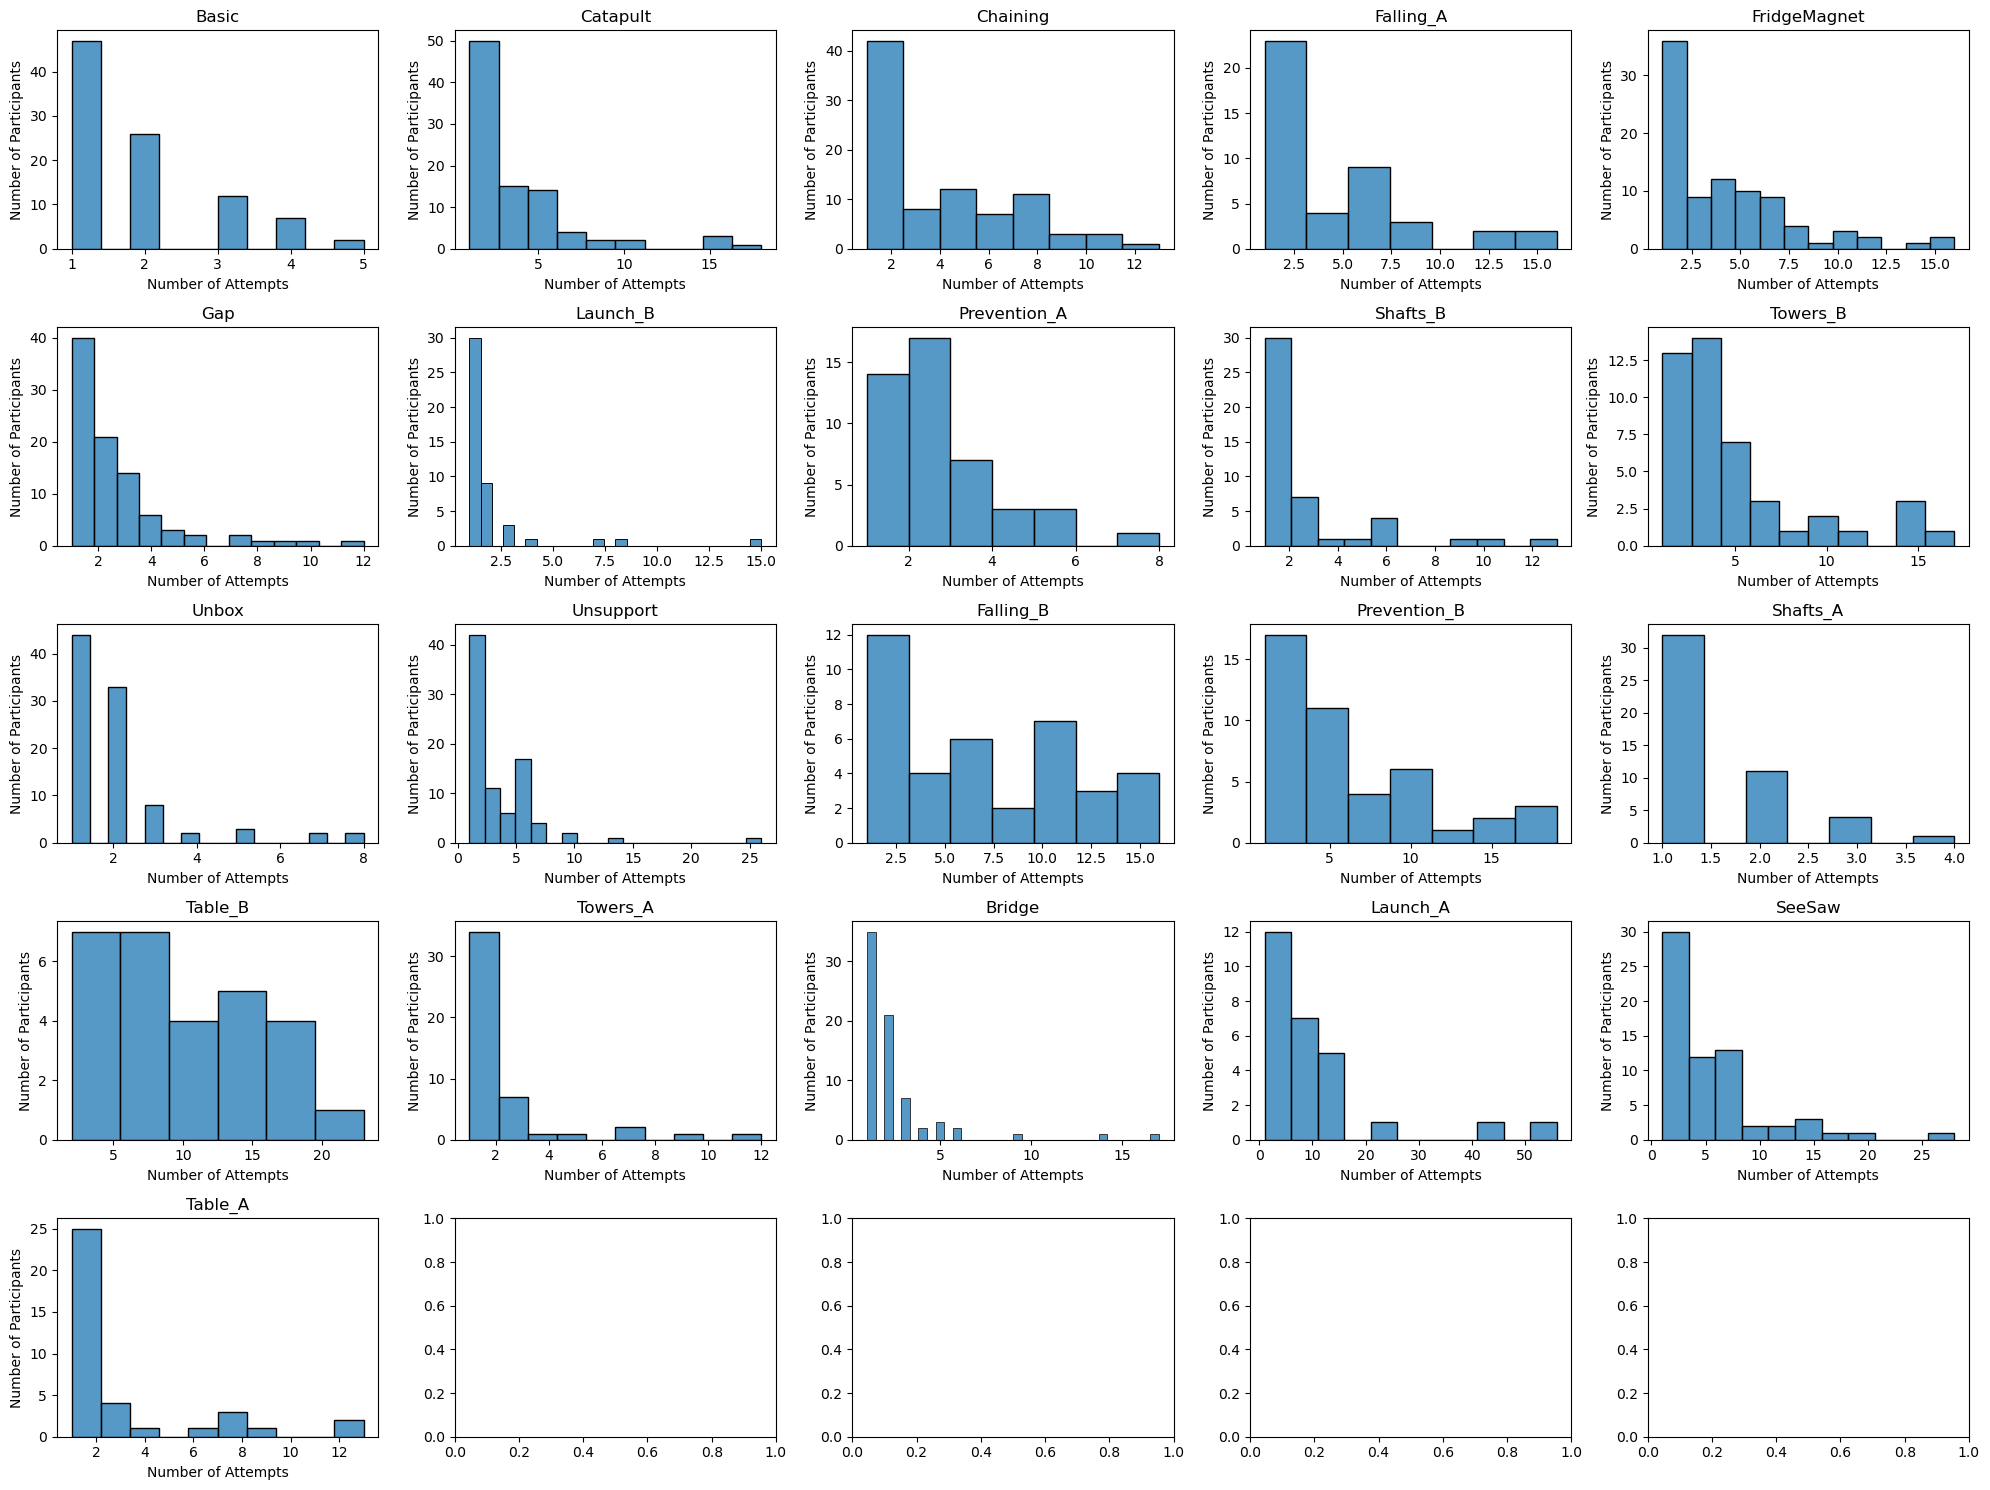

In [7]:
# plot grid of histograms for number of attempts per participant
fig, ax = plt.subplots(5, 5, figsize=(20, 15))
for i, tnm in enumerate(data['Trial'].unique()):
    X = data[data['Trial'] == tnm][['ID', 'AttemptNum']]
    # group by ID and get max number of attempts
    X = X.groupby(['ID'])['AttemptNum'].max() + 1
    # plot histogram
    sns.histplot(data=X, ax=ax[i//5, i%5], legend=False)
    ax[i//5, i%5].set_title(tnm)
    ax[i//5, i%5].set_xlabel('Number of Attempts')
    ax[i//5, i%5].set_ylabel('Number of Participants')
plt.tight_layout()
plt.show()

In [8]:
# get cluster and object switches for each task
trials = {
    'Unsupport':3, 
    'Chaining':2, 
    'Falling_A':2, 
    'Bridge':3, 
    'Table_B':3, 
    'Basic':1, 
    'Catapult':2,
    'Gap':3, 
    'SeeSaw':3, 
    'Unbox':3, 
    'Falling_B':2, 
    'Launch_A':1,
    'Launch_B':1, 
    'Prevention_A':2,
    'Prevention_B':2,
    'Shafts_A':2,
    'Shafts_B':2,
    'Table_A':3,
    'Towers_A':1,
    'Towers_B':2
}
dfs = {}
for tnm, c in trials.items():
    X = data[data['Trial'] == tnm]
    X = getTimeDist(X)
    X = getToolSwitches(X)
    if c > 1:
        X = getClustersSwitches(getClusteringModel(X[['PosX', 'PosY']], c), X)
    dfs[tnm] = X

In [21]:
def get_stats(dfs):
    # plot attempts vs. z-scored time for each task
    stats = {'Trial': [], 'ToolSwitches': [], 'ClusterSwitches': [], 'Neither': [], 'Participants': []}
    for i, tnm in enumerate(dfs.keys()):
        # keep track of data points at each attempt number
        tool_switches = 0
        cluster_switches = 0
        neither = 0
        for subj , df in dfs[tnm].groupby(['ID']):
            # find attempt num of last cluster switch
            if len(df) == 1:
                neither += 1
                continue
            # check if there was a cluster switch (for tasks with more than 1 cluster)
            if 'ClusterSwitch' in df.columns:
                last_switch = df[df['ClusterSwitch'] == 1]['AttemptNum'].max()
            else:
                last_switch = np.nan
            # check if there was a tool switch
            if last_switch is np.nan:
                last_switch = df[df['ToolSwitch'] == 1]['AttemptNum'].max()
                # discard data that contains neither
                if last_switch is np.nan:
                    neither += 1
                    continue
                tool_switches += 1
            else:
                cluster_switches += 1

        stats['Trial'].append(tnm)
        stats['ToolSwitches'].append(tool_switches/(cluster_switches + tool_switches + neither))
        stats['ClusterSwitches'].append(cluster_switches/(cluster_switches + tool_switches + neither))
        stats['Neither'].append(neither/(cluster_switches + tool_switches + neither))
        stats['Participants'].append(cluster_switches + tool_switches + neither)
    return pd.DataFrame(stats)

In [22]:
# generate plot for Unsupport
stats = get_stats(dfs)

In [33]:
stats.sort_values(by=['ClusterSwitches', 'ToolSwitches'], ascending=False).round(3).to_csv('stats-cluster.csv', index=False)

In [34]:
stats.sort_values(by=['ToolSwitches'], ascending=False).round(3).to_csv('stats-tool.csv', index=False)

<AxesSubplot: >

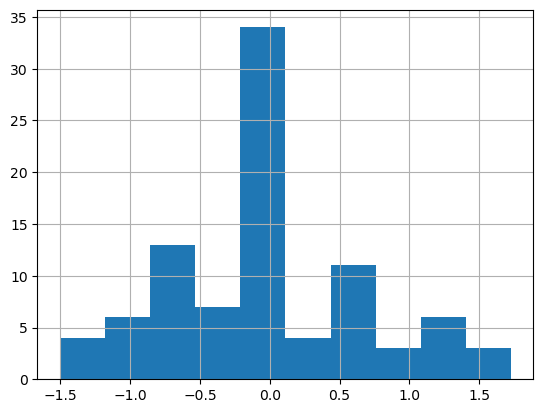

In [10]:
dfs['Launch_B'].TimeZ.hist()

In [ ]:
def generate_plots_filtered_by_attempts_cluster(dfs):
    # plot attempts vs. z-scored time for each task
    stats = {'Trial': [], 'ToolSwitches': [], 'ClusterSwitches': [], 'Neither': [], 'Participants': [], 'Attempts': []}
    for i, tnm in enumerate(dfs.keys()):
        # get df
        cur_df = dfs[tnm]
        if 'ClusterSwitch' not in cur_df.columns:
            continue
        max_num_attempts = cur_df['AttemptNum'].max()
        for j in range(3, max_num_attempts+1):
            filtered = cur_df.groupby(['ID']).filter(lambda x: x.AttemptNum.max() == j-1)
            if len(filtered) == 0:
                continue
            fig, ax = plt.subplots(figsize=(15, 10))
            data = np.zeros(121)
            range_min = 0
            range_max = 0
            n_subj = 0
            for subj , df in filtered.groupby(['ID']):
                # check if there was a cluster switch (for tasks with more than 1 cluster)
                last_switch = df[df['ClusterSwitch'] == 1]['AttemptNum'].max()
                if last_switch is np.nan:
                    continue
                # center data around last switch
                x = (df['AttemptNum'] - last_switch).to_numpy()
                if x[0] < range_min:
                    range_min = x[0]
                if x[-1] > range_max:
                    range_max = x[-1]
                y = df['TimeZ'].to_numpy()

                data[60-last_switch:60+x[-1]+1] += y

                n_subj += 1

            before = len(data)
            data = np.trim_zeros(data)/n_subj
            # plot data
            x = np.arange(range_min, range_max+1)

            try:
                sns.lineplot(x=x, y=data, ax=ax, legend=False, linestyle='--', marker='o', color='black', markersize=7)
            except:
                print(f'Error plotting {tnm}')
                print(len(x), before, len(data))
                continue
            # plot vertical line at last switch
            ax.set_xlabel('Attempt to insight')
            ax.set_ylabel('Z-Scored Time')
            ax.set_title(f'{tnm}')
            if len(x)%2 == 0 and len(x) > 25:
                ax.set_xticks(x[::2])
            elif len(x)%2 == 0 and len(x) > 25:
                ax.set_xticks(x[1::2])

            plt.tight_layout()
            plt.savefig(f'plotsCluster/{tnm}_{j}.png')
            plt.clf()
            plt.close()

In [ ]:
generate_plots_filtered_by_attempts_cluster(dfs)

In [35]:
def generate_plots_clusters(dfs):
    # plot attempts vs. z-scored time for each task
    for i, tnm in enumerate(dfs.keys()):
        # keep track of data points at each attempt number
        attempt_dict = {i:1 for i in range(101)}
        cluster_switches = 0
        data = np.zeros(121)
        range_min = 0
        range_max = 0
        fig, ax = plt.subplots(figsize=(15, 10))
        cur_df = dfs[tnm].groupby(['ID']).filter(lambda x: x.AttemptNum.max() <= 15)
        cur_df = cur_df.groupby(['ID']).filter(lambda x: x.AttemptNum.max() >= 3)
        for subj , df in cur_df.groupby(['ID']):
            # check if there was a cluster switch (for tasks with more than 1 cluster)
            if 'ClusterSwitch' in df.columns:
                last_switch = df[df['ClusterSwitch'] == 1]['AttemptNum'].max()
            else:
                last_switch = np.nan
            # check if there was a tool switch
            if last_switch is np.nan:
                continue

            cluster_switches += 1

            # center data around last switch
            x = (df['AttemptNum'] - last_switch).to_numpy()
            if x[0] < range_min:
                range_min = x[0]
            if x[-1] > range_max:
                range_max = x[-1]
            y = df['TimeZ'].to_numpy()
            for i, j in zip(range(60-last_switch, 60+x[-1]+1), range(len(y))):
                data[i] = (data[i]*attempt_dict[i] + y[j])/(attempt_dict[i]+1)
                attempt_dict[i] += 1
        
        if cluster_switches == 0:
            plt.clf()
            plt.close()
            continue
        # plot data
        x = np.arange(range_min, range_max+1)
        data_before = data
        data = np.trim_zeros(data)
        try:
            sns.lineplot(x=x, y=data, ax=ax, legend=False, linestyle='--', marker='o', color='black', markersize=7)
        except:
            print(f'Error plotting {tnm}')
            print(len(x), len(data), print(data_before))
            continue
        ax.set_xlabel('Attempt to insight')
        ax.set_ylabel('Z-Scored Time')
        ax.set_title(f'{tnm} - Cluster Switch')
        ax.set_ylim(-2, 2)
        ax.axvline(x=0, color='red', linestyle='--')
        if len(x)%2 == 0 and len(x) > 25:
            ax.set_xticks(x[::2])
        elif len(x)%2 == 0 and len(x) > 25:
            ax.set_xticks(x[1::2])

        plt.tight_layout()
        plt.savefig(f'plotsCluster/{tnm}.png')
        plt.clf()
        plt.close()


In [36]:
generate_plots_clusters(dfs)

In [37]:
def generate_plots_tools(dfs):
    # plot attempts vs. z-scored time for each task
    for i, tnm in enumerate(dfs.keys()):
        # keep track of data points at each attempt number
        attempt_dict = {i:1 for i in range(101)}
        tool_switches = 0
        cluster_switches = 0
        neither = 0
        data = np.zeros(121)
        range_min = 0
        range_max = 0
        num_subj = 0
        fig, ax = plt.subplots(figsize=(15, 10))
        cur_df = dfs[tnm].groupby(['ID']).filter(lambda x: x.AttemptNum.max() <= 15)
        for subj , df in cur_df.groupby(['ID']):
            # find attempt num of last cluster switch
            if len(df) == 1:
                neither += 1
                continue
            # check if there was a cluster switch (for tasks with more than 1 cluster)
            if 'ClusterSwitch' in df.columns:
                last_switch = df[df['ClusterSwitch'] == 1]['AttemptNum'].max()
            else:
                last_switch = np.nan
            # check if there was a tool switch
            if last_switch is np.nan:
                last_switch = df[df['ToolSwitch'] == 1]['AttemptNum'].max()
                # discard data that contains neither
                if last_switch is np.nan:
                    neither += 1
                    continue
                tool_switches += 1
            else:
                cluster_switches += 1
                continue

            # center data around last switch
            x = (df['AttemptNum'] - last_switch).to_numpy()
            if x[0] < range_min:
                range_min = x[0]
            if x[-1] > range_max:
                range_max = x[-1]
            y = df['TimeZ'].to_numpy()
            for i, j in zip(range(60-last_switch, 60+x[-1]+1), range(len(y))):
                data[i] = (data[i]*attempt_dict[i] + y[j])/(attempt_dict[i]+1)
                attempt_dict[i] += 1
        
        if tool_switches == 0:
            plt.clf()
            plt.close()
            continue
        # plot data
        x = np.arange(range_min, range_max+1)
        data_before = data
        data = np.trim_zeros(data)
        try:
            sns.lineplot(x=x, y=data, ax=ax, legend=False, linestyle='--', marker='o', color='black', markersize=7)
        except:
            print(f'Error plotting {tnm}')
            print(len(x), len(data), print(data_before))
            continue
        ax.set_xlabel('Attempt to insight')
        ax.set_ylabel('Z-Scored Time')
        ax.set_title(f'{tnm} - Tool Switch')
        ax.set_ylim(-2, 2)
        ax.axvline(x=0, color='red', linestyle='--')
        if len(x)%2 == 0 and len(x) > 25:
            ax.set_xticks(x[::2])
        elif len(x)%2 == 0 and len(x) > 25:
            ax.set_xticks(x[1::2])

        plt.tight_layout()
        plt.savefig(f'plotsTool/{tnm}.png')
        plt.clf()
        plt.close()

In [38]:
generate_plots_tools(dfs)

In [16]:
def generate_plots_cluster_subj(dfs):
    # plot attempts vs. z-scored time for each task
    for i, tnm in enumerate(dfs.keys()):
        cur_df = dfs[tnm].groupby(['ID']).filter(lambda x: x.AttemptNum.max() <= 15)
        cur_df = cur_df.groupby(['ID']).filter(lambda x: x.AttemptNum.max() >= 2)
        for subj , df in cur_df.groupby(['ID']):
            # find attempt num of last cluster switch
            if len(df) < 2:
                continue
            # check if there was a cluster switch (for tasks with more than 1 cluster)
            if 'ClusterSwitch' in df.columns:
                last_switch = df[df['ClusterSwitch'] == 1]['AttemptNum'].max()
            else:
                continue
            
            if last_switch is np.nan:
                continue

            # center data around last switch
            x = (df['AttemptNum'] - last_switch).to_numpy()
            y = df['TimeZ'].to_numpy()

            fig, ax = plt.subplots(figsize=(15, 10))
        
            # plot data
            try:
                sns.lineplot(x=x, y=y, ax=ax, legend=False, linestyle='--', marker='o', color='black', markersize=7)
            except:
                print(f'Error plotting {tnm}')
                print(len(x), len(y), x, y)
                continue
            ax.set_xlabel('Attempt to insight')
            ax.set_ylabel('Z-Scored Time')
            ax.set_title(f'{tnm} - Cluster Switch')
            if len(x)%2 == 0 and len(x) > 25:
                ax.set_xticks(x[::2])
            elif len(x)%2 == 0 and len(x) > 25:
                ax.set_xticks(x[1::2])

            plt.tight_layout()
            os.makedirs(f'plotsClusterSubj/{tnm}', exist_ok=True)
            plt.savefig(f'plotsClusterSubj/{tnm}/{tnm}-{subj}.png')
            plt.clf()
            plt.close()

In [17]:
generate_plots_cluster_subj(dfs)

In [18]:
def generate_plots_tools_subj(dfs):
    # plot attempts vs. z-scored time for each task
    for i, tnm in enumerate(dfs.keys()):
        cur_df = dfs[tnm].groupby(['ID']).filter(lambda x: x.AttemptNum.max() <= 15)
        cur_df = cur_df.groupby(['ID']).filter(lambda x: x.AttemptNum.max() >= 2)
        for subj , df in cur_df.groupby(['ID']):
            # find attempt num of last cluster switch
            if len(df) < 2:
                continue
            # check if there was a cluster switch (for tasks with more than 1 cluster)
            if 'ToolSwitch' in df.columns:
                last_switch = df[df['ToolSwitch'] == 1]['AttemptNum'].max()
            else:
                continue
            # check if there was a tool switch
            if last_switch is np.nan:
                continue

            # center data around last switch
            x = (df['AttemptNum'] - last_switch).to_numpy()
            y = df['TimeZ'].to_numpy()

            fig, ax = plt.subplots(figsize=(15, 10))
        
            # plot data
            sns.lineplot(x=x, y=y, ax=ax, legend=False, linestyle='--', marker='o', color='black', markersize=7)
            ax.set_xlabel('Attempt to insight')
            ax.set_ylabel('Z-Scored Time')
            ax.set_title(f'{tnm} - Tool Switch')
            if len(x)%2 == 0 and len(x) > 25:
                ax.set_xticks(x[::2])
            elif len(x)%2 == 0 and len(x) > 25:
                ax.set_xticks(x[1::2])

            plt.tight_layout()
            os.makedirs(f'plotsToolSubj/{tnm}', exist_ok=True)
            plt.savefig(f'plotsToolSubj/{tnm}/{tnm}-{subj}.png')
            plt.clf()
            plt.close()

In [19]:
generate_plots_tools_subj(dfs)